# Exercise IX: The Haxby Experiment (2001)

Thie exercise is based on [an example](https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html#sphx-glr-auto-examples-plot-decoding-tutorial-py) from [nilearn](https://nilearn.github.io/index.html)'s documentation.

The Haxby Experiment (2001) {cite}`haxby2001distributed` shows that the representation of objects from different categories is distributed and overlaps over brain regions that were broadly considered to be "specialized" to particular stimuli categories (i.e. the fusiform area for faces and the parahippocampal place area for places). 

![Cats](https://nilearn.github.io/_images/sphx_glr_plot_haxby_stimuli_0021.png)
![Faces](https://nilearn.github.io/_images/sphx_glr_plot_haxby_stimuli_0041.png)
![Arrow](https://cdn.iconscout.com/icon/premium/png-256-thumb/down-arrow-281-1112287.png) 
[Decoding]
![Mask](https://nilearn.github.io/_images/sphx_glr_plot_haxby_masks_0011.png)
![Classification](https://nilearn.github.io/_images/sphx_glr_plot_haxby_full_analysis_0011.png)

For the purposes of this exercise, we will predict stimulus categories based on the signal acquired from the ventral temporal cortex alone. This demonstration will show that while there was some expected variation, classification performance was relatively high across categories.

Let's start things off by using `nilearn`'s [`datasets`](https://nilearn.github.io/modules/reference.html) module to download a single subjects dataset:

In [1]:
from nilearn import datasets

haxby_data = datasets.fetch_haxby()

In [2]:
haxby_data

{'anat': ['/home/flavus/nilearn_data/haxby2001/subj2/anat.nii.gz'],
 'func': ['/home/flavus/nilearn_data/haxby2001/subj2/bold.nii.gz'],
 'session_target': ['/home/flavus/nilearn_data/haxby2001/subj2/labels.txt'],
 'mask_vt': ['/home/flavus/nilearn_data/haxby2001/subj2/mask4_vt.nii.gz'],
 'mask_face': ['/home/flavus/nilearn_data/haxby2001/subj2/mask8b_face_vt.nii.gz'],
 'mask_house': ['/home/flavus/nilearn_data/haxby2001/subj2/mask8b_house_vt.nii.gz'],
 'mask_face_little': ['/home/flavus/nilearn_data/haxby2001/subj2/mask8_face_vt.nii.gz'],
 'mask_house_little': ['/home/flavus/nilearn_data/haxby2001/subj2/mask8_house_vt.nii.gz'],
 'mask': '/home/flavus/nilearn_data/haxby2001/mask.nii.gz',
 'description': b'Haxby 2001 results\n\n\nNotes\n-----\nResults from a classical fMRI study that investigated the differences between\nthe neural correlates of face versus object processing in the ventral visual\nstream. Face and object stimuli showed widely distributed and overlapping\nresponse pattern

Review the dataset's description:

In [3]:
print(haxby_data.description.decode())

Haxby 2001 results


Notes
-----
Results from a classical fMRI study that investigated the differences between
the neural correlates of face versus object processing in the ventral visual
stream. Face and object stimuli showed widely distributed and overlapping
response patterns.

Content
-------
The "simple" dataset includes
    :'func': Nifti images with bold data
    :'session_target': Text file containing session data
    :'mask': Nifti images with employed mask
    :'session': Text file with condition labels


The full dataset additionally includes
    :'anat': Nifti images with anatomical image
    :'func': Nifti images with bold data
    :'mask_vt': Nifti images with mask for ventral visual/temporal cortex
    :'mask_face': Nifti images with face-reponsive brain regions
    :'mask_house': Nifti images with house-reponsive brain regions
    :'mask_face_little': Spatially more constrained version of the above
    :'mask_house_little': Spatially more constrained version of the abov

## Visualization

fMRI data is generally represented as a 4D matrix of 3D EPI scans over time. 

To read the fMRI volume from a *.nii.gz* file we'll use [nibabel](https://nipy.org/nibabel/)'s `load()` function:

In [4]:
from nilearn import plotting
import nibabel as nib

fmri_path = haxby_data.func[0]
fmri_data = nib.load(fmri_path)
fmri_data.shape

(40, 64, 64, 1452)

To plot a 3D image representing the mean fMRI signal over time for the single subject in the dataset:


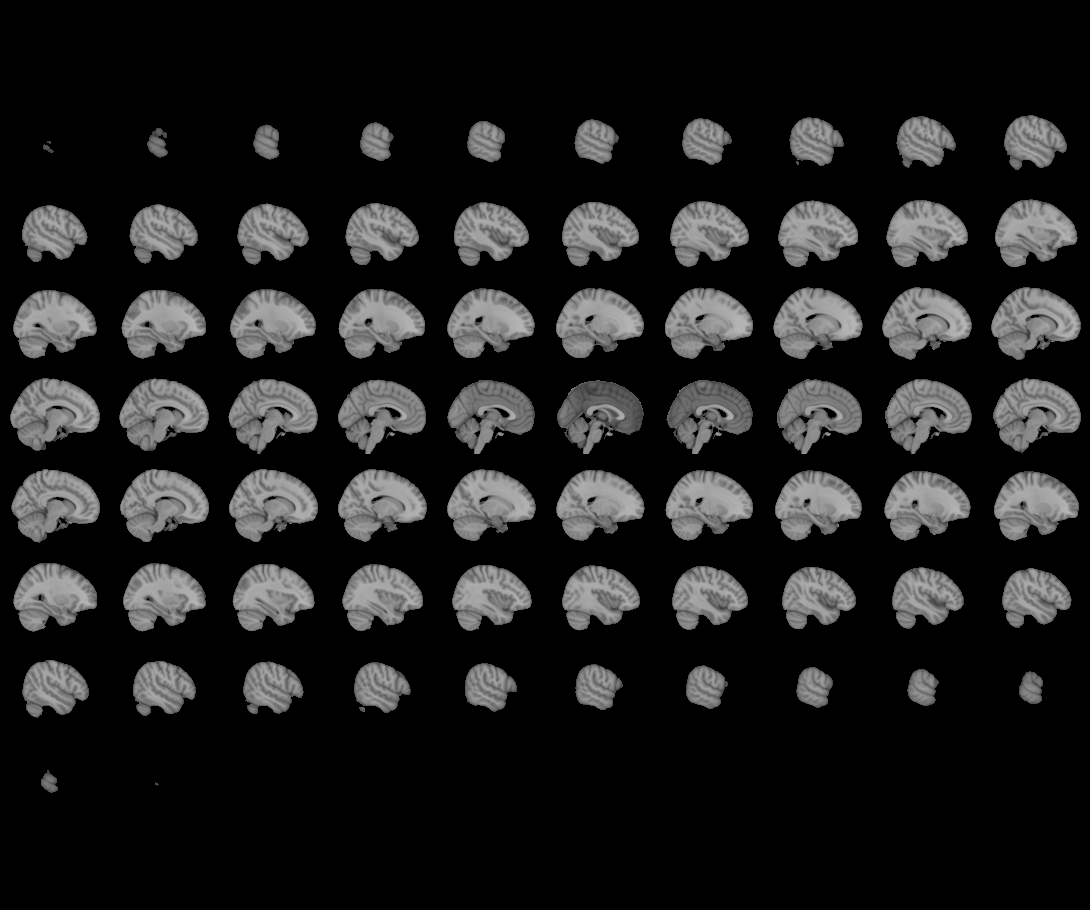
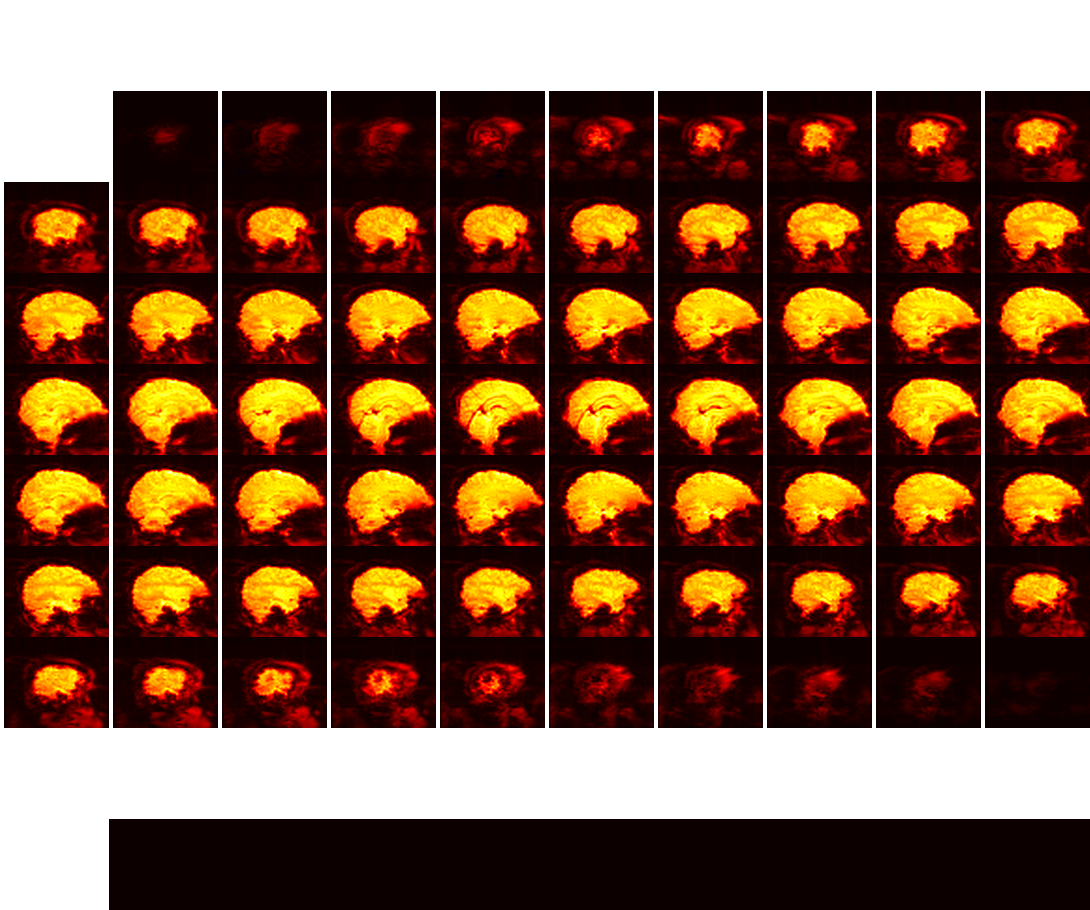

In [5]:
from nilearn.image import mean_img

fmri_mean_epi = mean_img(fmri_data)
plotting.view_img(fmri_mean_epi, threshold=None)

## Masking

In order to analyze the data, we need to produce a matrix containing the measured signal in the ventral temporal (VT) cortex over time.

First, let's have a look at the provided mask:

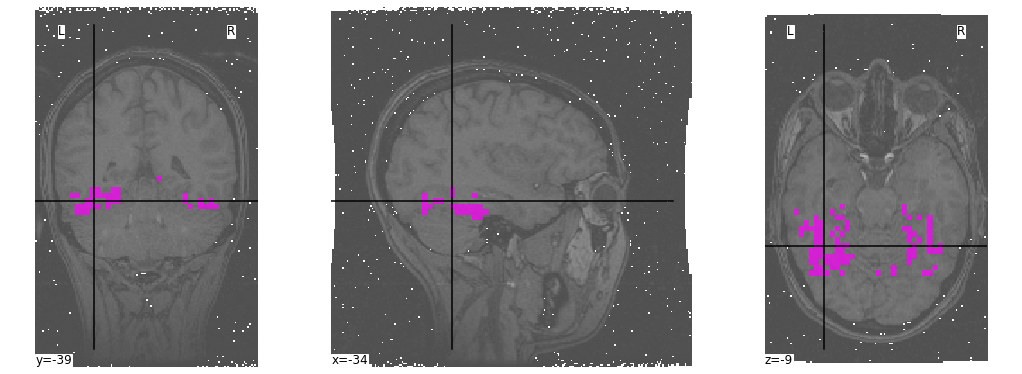

In [6]:
import matplotlib.pyplot as plt

mask = haxby_data.mask_vt[0]
anatomical = haxby_data.anat[0]

figure = plt.figure(figsize=(14, 5))
_ = plotting.plot_roi(mask,
                      bg_img=anatomical,
                      cmap="spring",
                      black_bg=False,
                      figure=figure)

Now, we will use this ROI in order to mask our 4D fMRI data:

![Masking illustration](https://nilearn.github.io/_images/masking.jpg)

In [7]:
from nilearn.input_data import NiftiMasker

masker = NiftiMasker(mask_img=mask, standardize=True)
masked_data = masker.fit_transform(fmri_data)

The result containts time points as rows and voxels as columns:

In [8]:
masked_data.shape

(1452, 464)

For example, to plot the change in the measured signal in some 5 voxels over time:

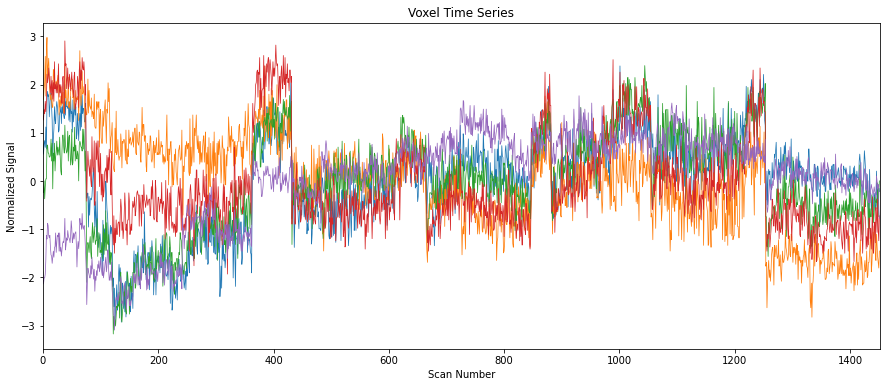

In [9]:
START_VOXEL, END_VOXEL = 0, 5
SIGNAL_PLOT_CONFIGURATION = {
    "title": "Voxel Time Series",
    "xlabel": "Scan Number",
    "ylabel": "Normalized Signal",
    "xlim": (0, len(masked_data))
}

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(masked_data[:, START_VOXEL:END_VOXEL], linewidth=0.75)
_ = ax.set(**SIGNAL_PLOT_CONFIGURATION)

## Prediction

Let's try and predict which stimulus category the subject was viewing based on the masked fMRI data.

### Reading the labels

The `session_target` file contains a `labels` column, describing the stimulus category at each presentation block, as well as the session (`chunks`) out of 12 sessions presented to each subjects.

In [10]:
import pandas as pd

LABEL_COLUMNS = {'labels': 'Label', 'chunks': 'Session'}

labels_path = haxby_data.session_target[0]
labels = pd.read_csv(labels_path, delimiter=' ')
labels.rename(columns=LABEL_COLUMNS, inplace=True)
labels

,Label,Session
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
...,...,...
1447,rest,11
1448,rest,11
1449,rest,11
1450,rest,11


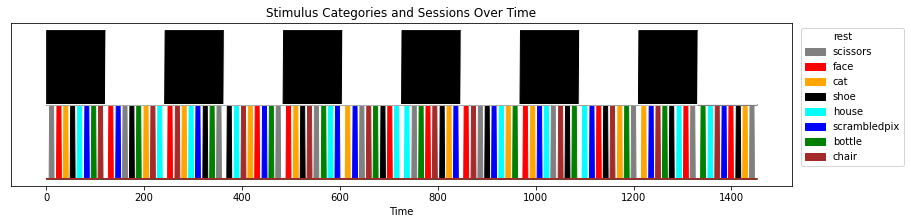

In [12]:
import numpy as np

LABEL_COLORS = {
    "rest": "white",
    "scissors": "grey",
    "face": "red",
    "cat": "orange",
    "shoe": "black",
    "house": "cyan",
    "scrambledpix": "blue",
    "bottle": "green",
    "chair": "brown"
}


def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels))
              if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=(1.15, 1))


category_fig, category_ax = plt.subplots(figsize=(14, 3))
for label in labels.Label.unique():
    y1 = np.zeros(len(labels))
    y2 = np.ones(len(labels)) * (labels.Label == label)
    category_ax.fill_between(labels.index,
                             y1,
                             y2,
                             color=LABEL_COLORS[label],
                             label=label)
for session_id in labels.Session.unique():
    color = "black" if session_id % 2 == 0 else "white"
    y1 = np.ones(len(labels))
    y2 = np.ones(len(labels))
    y2[labels.Session == session_id] = 2
    category_ax.fill_between(labels.index, y1, y2, color=color)
legend_without_duplicate_labels(category_ax)
_ = category_ax.set(title="Stimulus Categories and Sessions Over Time",
                    yticks=[],
                    xlabel="Time")

Let's create a couple of references to the given data for comfort and readability.

In [13]:
is_task = labels["Label"] != 'rest'

task_data = masked_data[is_task]
task_labels = labels["Label"][is_task]
task_sessions = labels["Session"][is_task]

categories = task_labels.unique()

### Logistic Regression

To grid search across $\ell_1$ and $\ell_2$ with various `C` values and score based on the ROC AUC:

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut

SOLVER = "liblinear"  # See note 1
model = LogisticRegression(random_state=0, solver=SOLVER)
C = [10**i for i in range(-2, 3)]
PARAM_GRID = {"C": C, "penalty": ["l1", "l2"]}
SCORING = "roc_auc"

searcher = GridSearchCV(model,
                        param_grid=PARAM_GRID,
                        scoring=SCORING,
                        cv=LeaveOneGroupOut())  # See note 2

```{note}
`sklearn` offers a variety of different solvers for logistic regression, in our case we need to make sure we use one that supports both $\ell_1$ and $\ell_2$ regularization. For more information, see the `LogistricRegression` model's [user guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). 
```

```{note}
The fMRI data is acquired by sessions, and the noise is autocorrelated in a given session. Hence, it is better to predict across sessions when doing cross-validation.
```

Our goal now it to evaluate how well we manage to classify the target category of stimuli based on the signal from the verntral temporal cortex alone:

In [15]:
# Create a DataFrame to store the results
scores = pd.DataFrame(index=categories, columns=["Penalty", "C", "AUC"])

# Iterate categories and updates best scores
for category in categories:
    target = task_labels == category
    searcher.fit(
        X=task_data,
        y=target,
        groups=task_sessions,
    )
    cv_results = searcher.cv_results_
    scores.loc[category, "Penalty"] = searcher.best_estimator_.penalty
    scores.loc[category, "C"] = searcher.best_estimator_.C
    scores.loc[category, "AUC"] = searcher.best_score_

In [16]:
scores

,Penalty,C,AUC
scissors,l2,10,0.912551
face,l1,1,0.986919
cat,l2,100,0.961052
shoe,l2,1,0.925779
house,l1,0.1,0.998089
scrambledpix,l1,10,0.989418
bottle,l1,1,0.898883
chair,l1,10,0.93107


Not bad! Clearly, the ventral temporal cortex has some significant value in decoding the represenation of the various stimulus categories (and not just faces).